In [1]:
%matplotlib inline
# Do not display warnings to prettify the notebook...
import warnings
warnings.simplefilter("ignore")

# Connectivity Analysis Pipeline

This notebook showcases a connectivity analysis pipeline using **EBRAINS** atlas services through **siibra**, and **nilearn**.

## Getting Started

The following steps will help you get started quickly with `siibra` and `nilearn`. We start by trying to import the packages. If not found, they will be installed.

In [2]:
# import nilearn newest version (make sure it is 0.8.0 or more)
try:
    import nilearn
except:
    !pip install nilearn
    import nilearn
nilearn.__version__

'0.9.2'

We rely on the `siibra` library to work with EBRAINS human brain atlas and access the *Julich-Brain Probabilistic Cytoarchitectonic Maps*.

In [3]:
try:
    import siibra
except:
    !pip install siibra
    import siibra
siibra.__version__

[siibra:INFO] Version: 0.3a27
[siibra:WARNING] This is a development release. Use at your own risk.
[siibra:INFO] Please file bugs and issues at https://github.com/FZJ-INM1-BDA/siibra-python.


'0.3a27'

Alternatively, you can install the most recent development version of siibra directly from github:

```shell
git clone https://github.com/FZJ-INM1-BDA/siibra-python.git
cd siibra-python/
pip install -e .
```

### Prerequisite: Allow  `siibra` to connect to the EBRAINS Knowledge Graph

Most of the features linked to atlas regions are curated datasets in the [EBRAINS knowledge graph](https://kg.ebrainseu) (KG). To fetch data from the KG, you need to pass an EBRAINS KG authentication token to siibra. There are several ways to obtain a token, we will instruct `siibra` to use the device flow mechanism which is suitable for interactive use. As a prerequisite, you need to register for an EBRAINS account, as described [here](https://ebrains.eu/register).

In [4]:
# import os
# os.environ['SIIBRA_ENABLE_DEVICE_FLOW'] = 'true'
# siibra.fetch_ebrains_token()

## Pipeline Steps

The pipeline will ideally contains the following steps:

- **Step 1:** <a href='#Step1'>Load fmri data from EBRAINS</a>
- **Step 2:** <a href='#Step2'>Load a parcellation from EBRAINS human brain atlas using the `siibra` client</a>
- **Step 3:** <a href='#Step3'>Use nilearn to extract signals</a>
- **Step 4:** <a href='#Step4'>Use nilearn to compute some connectivity from these signals</a>
- **Step 5:** <a href='#Step5'>Use nilearn to visualize this connectivity (as a matrix, as a graph...)</a>
- **Step 6:** <a href='#Step5'>Compare results with structural connectivity retrieved from EBRAINS</a>

## Step 1: Load fmri data

Ideally this will be loaded from **EBRAINS**. 

**TODOS:**

- [x] find and upload good datasets
    - Individual Brain Charting (IBC) data: https://search.kg.ebrains.eu/instances/3ca4f5a1-647b-4829-8107-588a699763c1
- [ ] find a way to fetch them easily 

For now, we rely on **Nilearn** for this.

We load development fmri data for 10 subjects:

In [5]:
# from nilearn.datasets import fetch_development_fmri
#
# # Ten subjects of brain development fmri data
# data = fetch_development_fmri(n_subjects=10)

# Fetch one IBC subject in 3mm resolution
data = {
    'func': "/home/yasmin/data/ibc/3mm/sub-01/ses-14/func/wrdcsub-01_ses-14_task-RestingState_dir-ap_bold.nii.gz",
    'confounds': "/home/yasmin/data/ibc/3mm/sub-01/ses-14/func/sub-01_ses-14_task-RestingState_dir-ap_desc-confounds_timeseries.tsv"
}

## Step 2: Load an atlas from EBRAINS

### 2.1 Fetch a parcellation object via siibra

Select a parcellation among the possible choices:

In [6]:
atlas = siibra.atlases['human']
parcellation = atlas.get_parcellation('julich')
print(parcellation.description)

[siibra:INFO] Multiple elements matched the specification 'julich' - the first in order was chosen: Julich-Brain Cytoarchitectonic Maps 2.9


This dataset contains the whole-brain parcellation of the Julich-Brain Cytoarchitectonic Atlas in the MNI ICBM 152 2009c nonlinear asymmetric reference space (Evans et al., 2012). The parcellation is derived from the individual probability maps (PMs) of the cytoarchitectonic regions released in the Julich-Brain Cytoarchitectonic Atlas, that are further combined into a Maximum Probability Map (MPM). The MPM is calculated by considering for each voxel the probability of all cytoarchitectonic areas released in the atlas, and determining the most probable assignment (Eickhoff 2005). Gap maps complement cortical maps to achieve full cortical coverage.


### 2.2 Retrieve a parcellation map in MNI152 space

We load the map for this parcellation in MNI152 space. The map is an object which provides access to possibly multiple labelled 3D volumes, and keeps track of the relationship between map indices, label indices and the corresponding regions. It follows a lazy data loading scheme. In order to load image data, the `fetch()` or `fetchall()` methods are used. While the first loads image data for one particular volumetric map (with the first one as the default), the latter provides an iterator over all available maps. 

For the Julich-Brain maximum probability parcellation, the map provides two labelled volumes for the left and right hemisphere, respectively:

In [8]:
jubrain_mpm = atlas.get_map(space="mni152", maptype="labelled")
print(f"Julich brain provides {len(jubrain_mpm)} labelled maps.")

[siibra:INFO] No parcellation specified, using default 'Julich-Brain Cytoarchitectonic Maps 2.9'.


Julich brain provides 2 labelled maps.


We iterate over the 3D image volumes, and display them:

In [10]:
from nilearn import plotting
for img in jubrain_mpm.fetch_iter():
    nilearn.plotting.plot_roi(img)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 2.3 Understand handling of region objects and map indices in siibra

The parcellation map allows us to decode map and label indices into region objects:

In [11]:
region1 = jubrain_mpm.decode_index(mapindex=0, labelindex=10)
print(region1)

Area hOc3v (LingG) left


In [12]:
region2 = jubrain_mpm.decode_index(mapindex=1, labelindex=10)
print(region2)

Area hOc3v (LingG) right


In the very same fashion we can access the more detailed probability maps for each region, by requesting the "continuous" map type. This gives us a parcellation map with hundreds of volumetric maps, each representing one brain region:

In [13]:
jubrain_pmaps = atlas.get_map(space="mni152", maptype="continuous")

[siibra:INFO] No parcellation specified, using default 'Julich-Brain Cytoarchitectonic Maps 2.9'.
Loading spatial index for 296 continuous maps: 100%|██████████| 1551658/1551658 [00:04<00:00, 356756.51voxels/s]


Let's fetch the probability map for region2 from above and plot it:

In [14]:
plotting.plot_stat_map(jubrain_pmaps.fetch_regionmap("hoc3v right"))

<IPython.core.display.Javascript object>

For the maximum probability map, the same will give us a binary mask of that region:

In [15]:
plotting.plot_roi(jubrain_mpm.fetch_regionmap("hoc3v right"))

<IPython.core.display.Javascript object>

## Step 3: Use Nilearn to extract signals from parcellation and functional data

In this section we use the nilearn `NiftiLabelsMasker` to extract the signals from the functional dataset and parcellation.

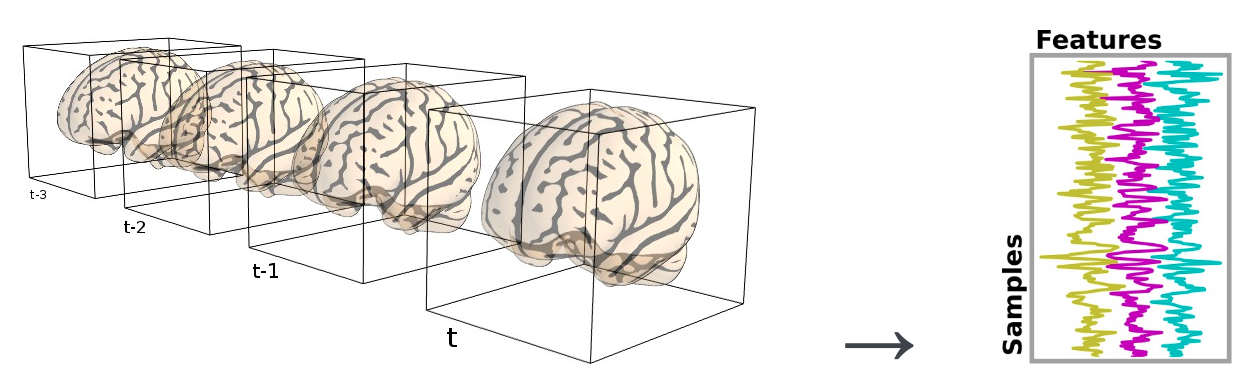

In [16]:
from IPython.display import Image
Image(filename='masker.png') 

*copyright - Image taken from the nilearn documentation.*

More information on maskers can be found in the <a href="https://nilearn.github.io/manipulating_images/masker_objects.html">nilearn online documentation</a>.

The parcellation and data images have different resolutions, which will have to be handled when computing the signals:

In [17]:
parcellation_map_niimg, regionnames = jubrain_mpm.fetch_relabelled()
parcellation_map_niimg.affine

100%|██████████| 2/2 [00:19<00:00,  9.54s/maps]


array([[   1.,    0.,    0.,  -96.],
       [   0.,    1.,    0., -132.],
       [   0.,    0.,    1.,  -78.],
       [   0.,    0.,    0.,    1.]])

In [18]:
from nilearn.image import load_img
load_img(data['func']).affine

array([[  -3.,    0.,    0.,   78.],
       [   0.,    3.,    0., -112.],
       [   0.,    0.,    3.,  -70.],
       [   0.,    0.,    0.,    1.]])

In [20]:
from nilearn.maskers import NiftiLabelsMasker
import numpy as np

names = regionnames
labels = list(regionnames.values())

# Use NiftiLabelsMasker to extract signals from regions
# Note that the masker will resample the parcellation to
# the data image resolution.
masker = NiftiLabelsMasker(labels_img = parcellation_map_niimg,
                           labels = labels,
                           background_label=0, # Default value, for clarity
                           resampling_target="data", # Default value
                           standardize=True) # Standardize the signals
time_series = []
for func, confounds in zip([data['func']], [data['confounds']]):
    time_series.append(masker.fit_transform(func,
                                            confounds=confounds))

labels = [names[l] for l in masker.labels_]
# Small regions could get wiped out of the label image
# due to resampling which may results in signals
# extracted from fewer regions than defined in the input
# parcellation map. Check left out areas:
diff = set(names.keys()) - set(masker.labels_)
left_out = list(map(names.get, diff))
for area in left_out:
    print(area)
    assert area not in labels

time_series = np.array(time_series)
time_series.shape, len(names), len(np.unique(parcellation_map_niimg.get_fdata())), len(labels)

MF (Amygdala) right


((1, 1120, 293), 294, 295, 293)

We have **293** standardized time series of length **1120** per subject.

We can plot them if needed:

In [21]:
import matplotlib.pyplot as plt

subject_id = 0
fig = plt.figure(figsize=(12,4))
for i in [0,1,2]:
    plt.plot(time_series[subject_id, :, i], 
             label=f"{labels[i]:30.30}")
plt.legend()
plt.xlim((0, 168))
plt.xlabel("Time", fontsize=15)
plt.title(f"Signals for subject {subject_id} for three regions", fontsize=15)
plt.tight_layout()

<IPython.core.display.Javascript object>

## Step 4: Use Nilearn to compute a connectivity matrix

Here we compute the correlation between these time series:

In [22]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform(time_series)
assert correlation_matrix.shape == (1, 293, 293)

In order to visualize this matrix, we take the mean accross subject:

In [23]:
mean_correlation_matrix = correlation_measure.mean_
assert mean_correlation_matrix.shape == (293, 293)

## Step 5: Use nilearn to visualize the connectivity

We can use **Nilearn** to visualize the connectivity, either as a matrix or as a graph:

### As a matrix

We can plot the matrix with the region names:

In [24]:
mean_correlation_matrix.shape, len(labels)

((293, 293), 293)

In [25]:
from nilearn.plotting import plot_matrix
# Mask the main diagonal for visualization:
np.fill_diagonal(mean_correlation_matrix, 0)
# matrices are ordered for block-like representation
# For readability show only first 40 labels
start = 0
end = 40
plot_matrix(mean_correlation_matrix[start:end, start:end],
            figure=(16, 16), 
            labels=labels[start:end],
            reorder=True)

<IPython.core.display.Javascript object>

### As a graph

In [28]:
from nilearn.plotting import plot_connectome, find_parcellation_cut_coords

# grab center coordinates for atlas labels
# !!!!! UGLY HACK ALERT !!!!!
# I'm passing the resampled label image from the masker to avoid shape errors
coordinates = find_parcellation_cut_coords(labels_img=masker._resampled_labels_img_)
# plot connectome with 95% edge strength in the connectivity
plot_connectome(mean_correlation_matrix, 
                coordinates,
                edge_threshold="95%")

<IPython.core.display.Javascript object>

## Step 6: Compare results with structural connectivity retrieved from EBRAINS